*UCSB MEDS* - *EDS 220 - Working With Environmental Datasets in Python*

# Pheonix Biodiversity Intactness Index Analysis
### Mapping the Change in Biodiversity from 2017 - 2020 in Phoenix, Arizona

**Author:** Nicole Pepper

![Python](https://img.shields.io/badge/Python-cornflowerblue?style=for-the-badge&logo=R) ![Remote Sensing](https://img.shields.io/badge/Remote_Sensing-green?style=for-the-badge) ![GIS](https://img.shields.io/badge/GIS-purple?style=for-the-badge)  ![UCSB MEDS](https://img.shields.io/badge/UCSB%20MEDS-blue?style=for-the-badge) 


<div style="text-align: left;">
  <img src="bii.jpg" alt="Image" width="900">
    

### About the Repo:
This notebook investigates the impacts of urban expansion by analyzing a dataset that captures values for the [Biodiversity Intactness Index (BII)](https://ai4edatasetspublicassets.blob.core.windows.net/assets/pdfs/io-biodiversity/Biodiversity_Intactness_whitepaper.pdf). [In 2021, Maricopa County —home to the Phoenix metropolitan area— was identified as the U.S. county with the most significant increase in developed land since 2001](https://www.washingtonpost.com/nation/interactive/2021/land-development-urban-growth-maps/). This rapid urban sprawl has profound implications for biodiversity and the health of surrounding natural ecosystems. I examine changes in BII in the Phoenix county subdivision area between 2017 and 2020, shedding light on how urban growth affects biodiversity over time.

**Link to Github:** https://github.com/nicolelpepper/phoenix-bii-analysis    
    
### Technical Highlights:
- Programming in Python using `Jupyter Lab`
- Data retreival from Microsoft STAC catalog with `pystac_client`
- Vector data wrangling with `gpd`
- Raster data wrangling with `rioxarray` and `xarray`
- Data visualization with `matplotlib`
- Creating a map gif with `geogif`
    
### Data Descriptions:

- The `Biodiversity Intactness Index (BII) Time Series` data generated by Impact Observatory, in collaboration with Vizzuality, these datasets estimate terrestrial Biodiversity Intactness as 100-meter gridded maps for the years 2017-2020. For my analysis, I use the 2017 and 2020 rasters that cover the Phoenix metro area. I accessed the data using the `io-biodiversity` collection from the [Microsoft Planetary Computer STAC catalog](https://planetarycomputer.microsoft.com/dataset/io-biodiversity).

- The `Pheonix Subdivision Shapefile` data is a shapefile containing the perimeters of the Pheonix metro area. It is a subset of the Census County Subdivision shapefiles for Arizona. The data is a subset of Census County Subdivision shapefiles from the [U.S. Census Bureau](https://www.census.gov/programs-surveys/acs) from 2020 for Arizona. I accessed it on the [U.S. Census Bureau website](https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2020&layergroup=County+Subdivisions). It is stored in my data folder as tl_2020_04_cousub.shp.

# 1. Set Up Workspace

To start my analysis, I set up my workspace by loading in the necessary libraries.

### 1a. Load libraries

In [1]:
# ---- Load libraries ----

# For importing project data from STAC API
from pystac_client import Client  # To access STAC catalogs
import planetary_computer  # To sign items from the MPC STAC catalog 

# For general data wrangling
import pandas as pd
import numpy as np
import geopandas as gpd 
import xarray as xr
import rioxarray as rioxr
from shapely.geometry import box
import xarray as xr
import requests

# For data visualization
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches  # for map legend
from IPython.display import Image  # to nicely display images
import contextily as cx # for map background data
from PIL import Image
from io import BytesIO

### 1b. Read in Project Data

Next, I load in my project data, starting with the Arizona subdivisions shapefile that is stored in my data folder.

In [2]:
# ----- Read in Phoenix subdivision boundary ------

# Read in Arizona subdivisions data
arizona_sds = gpd.read_file("data/tl_2020_04_cousub.shp")

# Subset to phoenix
phoenix = arizona_sds[arizona_sds['NAME'] == 'Phoenix']

Then, I use the Microsoft Planetary Computer STAC Catalog to access the BII data for my study area and time period (2017 & 2020).

In [3]:
# ----- Read in bii data ------

# Define Pheonix bbox
bbox = [-112.826843, 32.974108, -111.184387, 33.863574]

# ----- Access MPC catalog ------

# Access MPC catalog
catalog = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

# Access MPC collections as a list
catalog.get_collections()
collections = list(catalog.get_collections())


# Define temporal range for 2017 and 2020
time_ranges = ["2017-01-01/2017-12-31", "2020-01-01/2020-12-31"]

# Initialize an empty list to collect items
items = []

# Define for loop to iterate search for both time ranges
for time_range in time_ranges:
    search = catalog.search(
        collections=["io-biodiversity"],
        bbox=bbox,
        datetime=time_range
    )
    items.extend(list(search.items()))

# Print summary of found items
print(f"Found {len(items)} items matching the criteria.")

# Separate 2017 and 2020 images    
bii_2017_item = items[0]
bii_2020_item = items[1]

print(bii_2017_item.id)
print(bii_2020_item.id)

# ---- Retreive BII data from items ----

# Get 2017 Phoenix data
bii_2017 = bii_2017_item.assets["data"]

bii_2017 = rioxr.open_rasterio(bii_2017.href)

# Get 2020 Phoenix data

bii_2020 = bii_2020_item.assets["data"]

bii_2020 = rioxr.open_rasterio(bii_2020.href)

Found 2 items matching the criteria.
bii_2017_34.74464974521749_-115.38597824385106_cog
bii_2020_34.74464974521749_-115.38597824385106_cog


# 2. Prepare and Explore Preliminary Data

Now, it's time to explore my preliminary data.

### 2a. Check CRS

First, I'll check if the CRS for the data match:

In [4]:
# Check if CRS match
phoenix.crs == bii_2017.rio.crs

False

Since they don't, I'm going to reproject the Phoenix dataset to match the bii rasters.

In [5]:
# ---- Check CRS ----

# Set CRS to WGS 84 to match MPC data (EPSG: 4326) (bii_2017.rio.crs)
phoenix = phoenix.to_crs(bii_2017.rio.crs)

# Print the crs name 
print("The bii_2017 CRS is:", bii_2017.rio.crs)

# Print the crs name 
print("The bii_2020 CRS is:", bii_2020.rio.crs)

# Print the crs name
print("The phoenix CRS is:", phoenix.crs.name)

The bii_2017 CRS is: EPSG:4326
The bii_2020 CRS is: EPSG:4326
The phoenix CRS is: WGS 84


### 2b. Drop Bands for 2017 & 2020 BII Rasters

Now let's look at the BII data.

In [7]:
print(bii_2017.sizes)
print(bii_2020.sizes)

Frozen({'band': 1, 'y': 7992, 'x': 7992})
Frozen({'band': 1, 'y': 7992, 'x': 7992})


Since the BII data are single band rasters, we are going to remove the unecessary band dimension of length 1 to make it easier to work with.

In [8]:
# ---- Remove length 1 dimension ----

# Drop band for bii 2017
bii_2017 = bii_2017.squeeze().drop_vars('band')
print('Sizes of dimensions: ', dict(bii_2017.sizes))

# Drop band for bii 2020
bii_2020 = bii_2020.squeeze().drop_vars('band')
print('Sizes of dimensions: ', dict(bii_2020.sizes))

Sizes of dimensions:  {'y': 7992, 'x': 7992}
Sizes of dimensions:  {'y': 7992, 'x': 7992}


### 2c. Visualize Preliminary Data

Let's visualize the Arizona subdivisions and our subset for Phoenix:

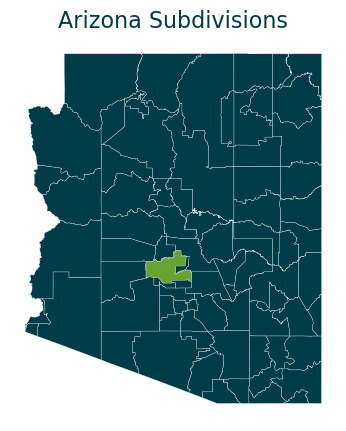

In [14]:
# ---- Map Arizona Subdivisions ----

# Set figure parameters
fig, ax = plt.subplots(figsize=(5, 5))

# Plot arizona subdivisions
arizona_sds.plot(ax=ax, color='#003B4A', edgecolor='white', linewidth = 0.2)

# Plot phoenix subdivision
phoenix.plot(ax=ax, color='#67A32F', edgecolor='white', linewidth = 0.2)

# Remove axes
ax.axis('off')

# Add a title and display the plot
plt.title("Arizona Subdivisions", fontsize=16, color='#003B4A')
plt.show()

Now let's take a preliminary look at the BII data.

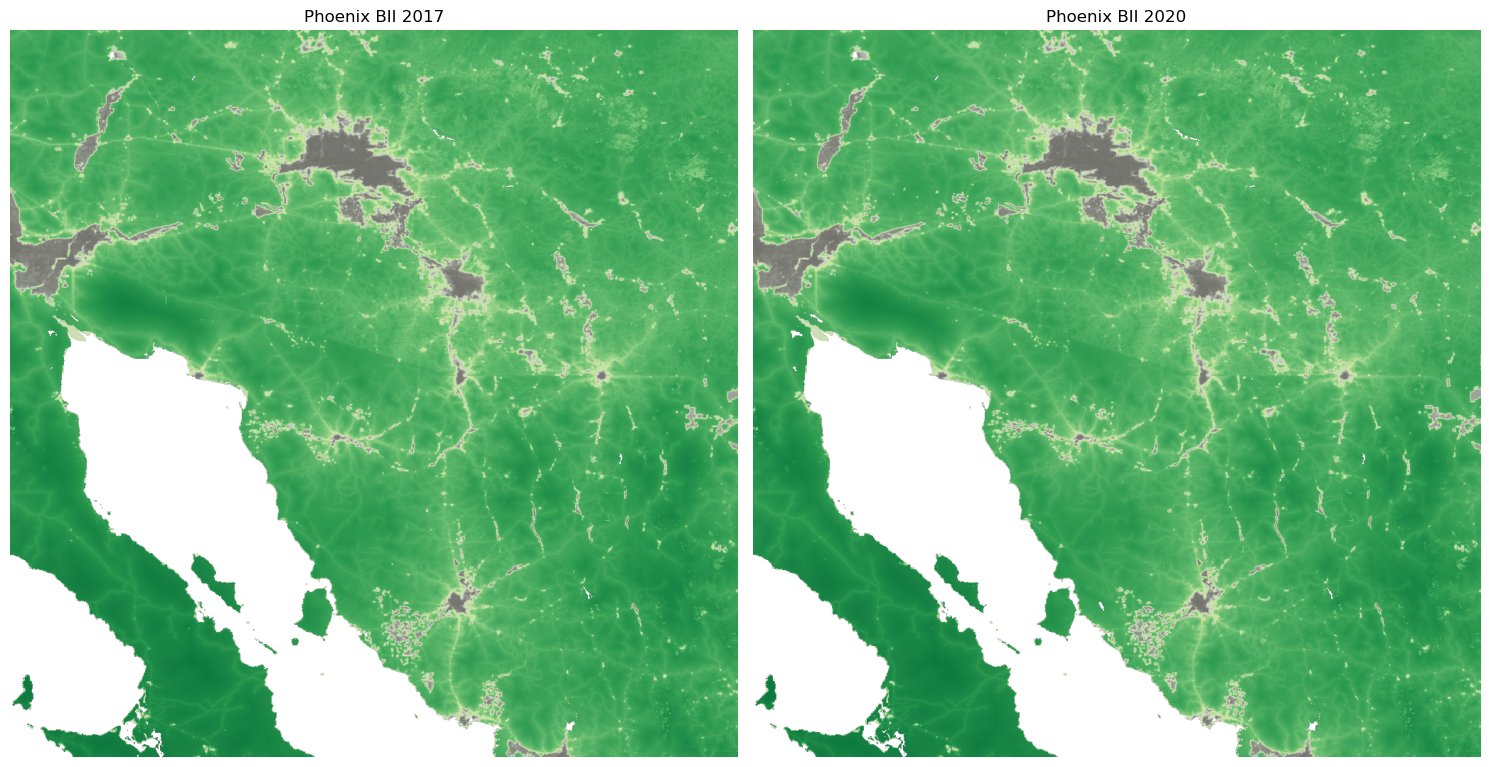

In [15]:
# ---- Retreive previews of bii data ----

# Define URLs for the 2017 and 2020 images
bii_2017_url = bii_2017_item.assets['rendered_preview'].href
bii_2020_url = bii_2020_item.assets['rendered_preview'].href

# Get image data from the URLs
request_2017 = requests.get(bii_2017_url)
request_2020 = requests.get(bii_2020_url)

# Load image data into a PIL Image object
image_2017 = Image.open(BytesIO(request_2017.content))
image_2020 = Image.open(BytesIO(request_2020.content))

# ---- Plot the previews side by side ----

# Set up fig with 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

# Display the 2017 image
ax1.imshow(image_2017)
ax1.set_title("Phoenix BII 2017")
ax1.axis('off')  # Turn off axes

# Display the 2020 image
ax2.imshow(image_2020)
ax2.set_title("Phoenix BII 2020")
ax2.axis('off')  # Turn off axes

plt.tight_layout()
plt.show()

Next, I'll clip the BII data to the Phoenix subdivision boundary.

In [16]:
# ---- Clip BII to Phoenix boundary ----

# Clip to Phoenix subdivision geometry in two steps to improve processing time
bii_2017_phoenix = bii_2017.rio.clip_box(*phoenix.total_bounds).rio.clip(phoenix.geometry, phoenix.crs, drop=True)
bii_2020_phoenix = bii_2020.rio.clip_box(*phoenix.total_bounds).rio.clip(phoenix.geometry, phoenix.crs, drop=True)

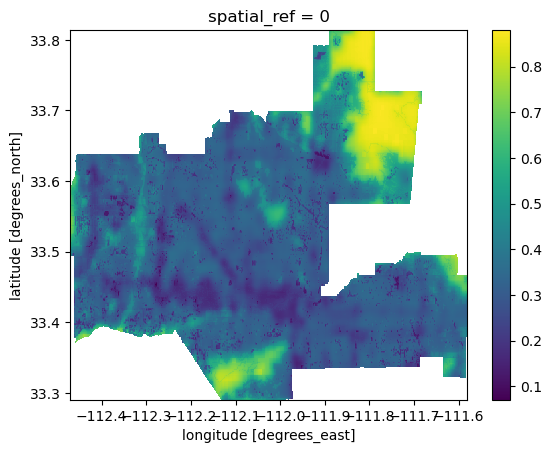

In [17]:
# Take a look at the 2017 BII clipped to Phoenix
bii_2017_phoenix.plot()

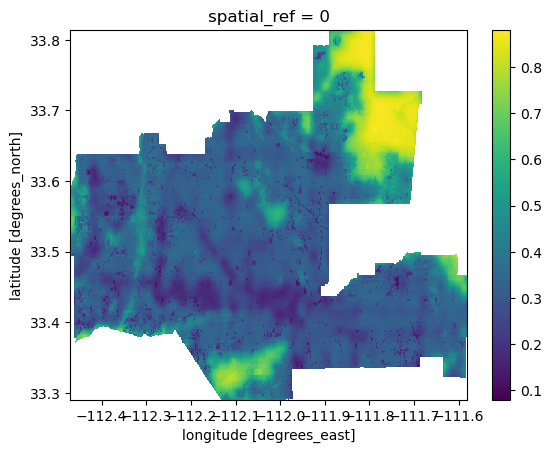

In [18]:
# Take a look at the 2020 BII clipped to Phoenix
bii_2020_phoenix.plot()

# 3. Calculate the Percentage of Area of the Phoenix Subdivision with a BII of at least 0.75 for 2017 and 2020

Now that our data is prepared, let's calculate the percent area of the Phoenix subdivisino with a BII of at least 0.75 for 2017 and 2020.

### 3a. Reclassify Data for Threshold Where *BII > 0.75*

In [20]:
# Select areas where BII > 0.75
bii_2017_75 = bii_2017_phoenix >= 0.75
bii_2020_75 = bii_2020_phoenix >= 0.75

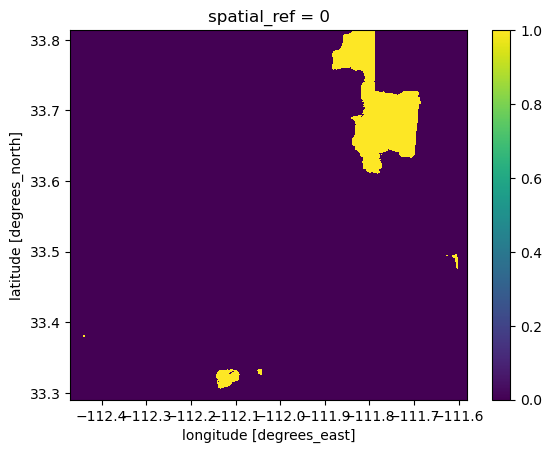

In [21]:
# Visualize results for 2017
bii_2017_75.plot()

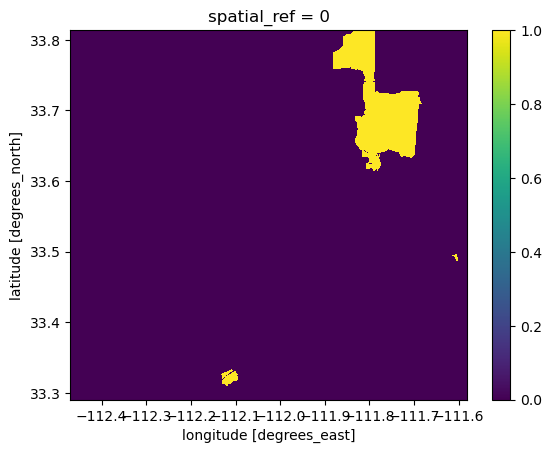

In [22]:
# Visualize results for 2020
bii_2020_75.plot()

### 3b. Calculate Percent Area for 2017 & 2020

To calculate the percent area, I create a df with the pixel value counts for 2017 and 2020.

In [23]:
# ---- Value Counts ----
values_2017, counts_2017 = np.unique(bii_2017_75.values, return_counts=True)
values_2020, counts_2020 = np.unique(bii_2020_75.values, return_counts=True)

# ---- Create df for bii area pixel counts ----
bii_area_2017 = pd.DataFrame({"gt_0.75" : values_2017,
                                "pixel_count" : counts_2017})
bii_area_2020 = pd.DataFrame({"gt_0.75" : values_2020,
                                "pixel_count" : counts_2020})

Then to get the total area for Phoenix I get the pixel count for the clipped Phoenix object.

In [29]:
# ---- Calculate total pixel count for Phoenix subdivision ----

# Subset to where it is greater than 0
phoenix_total_area = bii_2020_phoenix > 0

values, counts = np.unique(phoenix_total_area , return_counts=True)

# ---- Create df for total area pixel counts ----
phoenix_total_area = pd.DataFrame({"gt_0.75" : values,
                           "pixel_count" : counts})

phoenix_total_area = phoenix_total_area.iloc[1,1]

phoenix_total_area

338699

Then create a column for total area in the df and add another column to calculate the relative area for regions where BII > 0.75 (gt_0.75 = True) for 2017.

In [30]:
# ---- Calculate percent area for 2017 ----

# Add column for total area
bii_area_2017["total_area"] = phoenix_total_area

# Add column for percent area
bii_area_2017["percent_area"] = (bii_area_2017["pixel_count"] / phoenix_total_area) * 100

bii_area_2017

,gt_0.75,pixel_count,total_area,percent_area
0,False,553037,338699,163.282738
1,True,24133,338699,7.125206


Then I repeat the process for 2020.

In [31]:
# ---- Calculate percent area for 2020 ----

# Add column for total area
bii_area_2020["total_area"] = phoenix_total_area

# Add column for percent area
bii_area_2020["percent_area"] = (bii_area_2020["pixel_count"] / phoenix_total_area) * 100

bii_area_2020

,gt_0.75,pixel_count,total_area,percent_area
0,False,555184,338699,163.916634
1,True,21986,338699,6.491309


Then I separate to get the values for each and print the values below:

In [32]:
# ---- Select out area values ----
percent_bii_2017 = bii_area_2017.iloc[1,3]
percent_bii_2020 = bii_area_2020.iloc[1,3]
percent_bii_diff = bii_area_2017.iloc[1,3] - bii_area_2020.iloc[1,3]

In [33]:
print("The Percent Area that is > 0.75 BII is 2017: ", round(percent_bii_2017, 2), "%")
print("The Percent Area that is > 0.75 BII is 2020: ", round(percent_bii_2020, 2), "%")
print("The Difference in Percent Area that was > 0.75 BII from 2017 to 2020 is: ", round(percent_bii_diff, 2), "%")

The Percent Area that is > 0.75 BII is 2017:  7.13 %
The Percent Area that is > 0.75 BII is 2020:  6.49 %
The Difference in Percent Area that was > 0.75 BII from 2017 to 2020 is:  0.63 %


# 4. Create a Map that Highlights Regions Where BII > 0.75 in 2017 Were Lost By 2020

### 4a. Find Where 2017 *BII > 0.75* Was Lost By 2020

To make a map where BII > 0.75 in 2017 were lost by 2020, I want to convert bii_2017_75 and bii_2020_75 to integers and then subtract the 2020 image from 2017.

In [36]:
# ---- Identify areas of biodiversity loss ---

# Convert to integer for calculation
bii_2017_75_int = bii_2017_75.astype('int')
bii_2020_75_int = bii_2020_75.astype('int')

# Subtract 2020 from 2017
bii_diff = bii_2017_75_int - bii_2020_75_int

# Subset to bii_diff is 1
bii_loss = bii_diff.where(bii_diff == 1)

The preliminary results are below, the light blue highlights the areas that were lost:

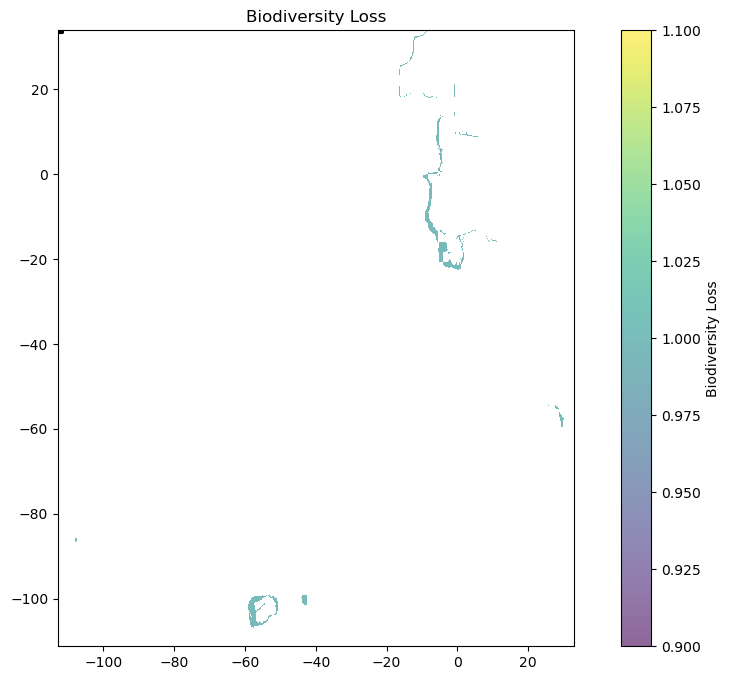

In [38]:
# ---- Plot Preliminary Results for Biodiversity Loss ----

# Define fig parameters
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the bii loss
cax = ax.imshow(
    bii_loss, 
    extent=bbox, 
    interpolation='none',
    alpha=0.6
)

phoenix.boundary.plot(ax=ax, edgecolor='black', linewidth=2)

# Add color bar and map elements
fig.colorbar(cax, ax=ax, orientation="vertical", label="Biodiversity Loss")
plt.title('Biodiversity Loss')

# Display the map
plt.show()

### 4b. Map Where 2017 *BII > 0.75* Was Lost By 2020
To make my final map, I'm plotting the Phoenix BII image, with the BII loss layer overlaid on top of it. I'm also including some other layers for context.

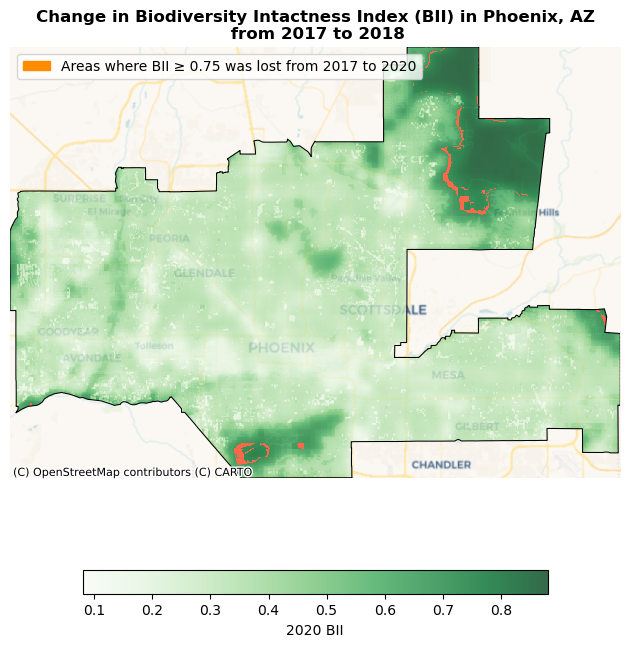

In [43]:
# Set up the plot
fig, ax = plt.subplots(figsize=(12, 8))

# ---- Add map layers ----

# Add BII for 2020
bii_2020_phoenix.plot(ax = ax,
                      cmap = "Greens",
                      alpha = 0.8,
                      cbar_kwargs = {"location": "bottom",
                                  "label": "2020 BII",
                                  "shrink" : 0.5})

# Plot BII loss
bii_loss.plot(ax = ax,
              cmap = 'Reds',
             add_colorbar = False)

# Add basemap with contextily clipped to Phoenix
cx.add_basemap(ax,
               crs=phoenix.crs,
             source=cx.providers.CartoDB.Voyager)

# Plot Phoenix subdivision boundary
phoenix.plot(ax = ax,
             color = "none",
             edgecolor = 'black',
             linewidth = 0.75)

# ---- Format Map & Legend ----

# Add title
plt.title('Change in Biodiversity Intactness Index (BII) in Phoenix, AZ\n from 2017 to 2018',
          weight = 'bold')


# Create legend bii loss
legend_bii_loss = mpatches.Patch(color = "darkorange",
                                 label = 'Areas where BII ≥ 0.75 was lost from 2017 to 2020')

# Plot legend for
ax.legend(handles = [legend_bii_loss],
    loc = "upper left")

# Turn off axis ticks for a cleaner map view
ax.set_axis_off()

# Display the map
plt.show()

This map shows the change in Biodiversity Intactness Index (BII) from 2017 to 2020 in Phoenix, Arizona. The map shows the BII level for 2020 ranging from 0.1 (light green) to 1 (dark green). Overlayed on that, are areas highlighted in orange that indicate where areas with a high BII, defined as BII greater than or equal to 0.75, were lost from 2017 to 2020. In that time period there was a decline in 0.63% areas with significant BII values.

### References:
  
- Vizzuality. (2022) *Biodiversity Intactness: White Paper*, https://ai4edatasetspublicassets.blob.core.windows.net/assets/pdfs/io-biodiversity/Biodiversity_Intactness_whitepaper.pdf.

- Vizzuality. [Data] [Biodiversity Intactness Index (BII) Time Series](https://planetarycomputer.microsoft.com/dataset/io-biodiversity) for 2017 and 2020. *Access date: 12/05/24* from https://planetarycomputer.microsoft.com/dataset/io-biodiversity

- U.S. Census Bureau (2020) [Data] Arizone Subdivisions Shapefile  *Access date: 12/05/24* https://www.census.gov/programs-surveys/acs